# Lab 02_1: Cooper pair box (CPB) vs Transmon Qubit

### modified by Seong Hyeon Park (pajoheji0909@snu.ac.kr)
### original code from Qiskit-Metal Tutorials #4

### Please find the attached homework at the end of this tutorial code

This module models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable. The Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the gauge-invariant phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The variables are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensiuonless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


The Hamiltonian can be written in the charge ($\hat n$) basis as: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$
Where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$

### Hcpb class

Hamiltonian-model Cooper pair box (Hcpb) class.

Used to model analytically the CPB Hamiltonian quickly
and efficiently. Solves in charge basis tridiagonal eigenvalue
problem for arbitrary $E_j$, $E_c$, $n_g$ values.

As long as nlevels remains fixed the number of charge states
considered does not change and it does not recreate the arrays,
just recomputes the properties

Returns all properties of interest for the CPB.

This model is closer to the analytic solution than the Duffing oscillator model.
Can work backwards from target qubit parameters to get the $E_j$, $E_c$ or use
input $E_j$, $E_c$ to find the spectrum of the Cooper Pair Box.

    @author: Christopher Warren (Chalmers University of Technology), updated by Zlatko K. Minev (IBM Quantum)
    @date: 2020, 2021



# Basic conversions
Automatic conversions between electrical variables and quantum mechanical variables

In [ ]:
import pyEPR.calcs
from pyEPR.calcs import Convert
print("Convert.toSI(1,'nH')     = ", Convert.toSI(1,'nH'), "H")
print("Convert.fromSI(1.0,'nH') = ", Convert.fromSI(1.0,'nH'), "nH")
print("Identity: ",                  Convert.toSI(Convert.fromSI(1.0,'nH'),'nH'))

In [ ]:
from IPython.display import Latex
Lj = 10 # nH
display(Latex(r"$E_J = %.2f \text{ GHz} \qquad \text{for } L_J=%.2f\text{ nH}$" % (Convert.Ej_from_Lj(Lj, 'nH', "GHz"),Lj)))

print('\nConvert back %.2f nH' % Convert.Lj_from_Ej(16.35E3, 'MHz', 'nH'),'\n')

display(Latex(r"$E_C = %.2f \text{ MHz} \qquad \text{for } C_S=%.2f\text{ fF}$" % (Convert.Ec_from_Cs(65., 'fF', "MHz"),65.)))

display( 'Convert back:',Latex(r"$C_S = %.2f \text{ fF} \qquad \text{for } E_C=%.2f\text{ MHz}$" % (Convert.Cs_from_Ec(300, 'MHz', "fF"),300)))

display(Latex(r'$I_c \text{ from } L_j = 10 \text{ nH is: } %.2f \text{ nA } \qquad L_J \text{ from } I_c = 32 \text{ nA is: } %.2f \text{ nH}$' % (Convert.Ic_from_Lj(10), Convert.Lj_from_Ic(32))))

In [ ]:
from pyEPR.calcs.convert import π, pi, ϕ0, fluxQ, Planck, ħ, hbar, elementary_charge, e_el
print("Test EJ raw calculation = %.2f"%( ϕ0**2 / (10E-9 * Planck) *1E-9 ) ,'GHz')

# (1) CPB type qubit analysis

In [ ]:
import math 
import numpy as np 
import matplotlib.pyplot as plt

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.HO_wavefunctions import wavefunction

A superconducting Cooper-pair box (CPB) and a transmon qubit share the same electrical circuit diagram.

The key difference lies in the ratio between Josephson energy ($E_J$) and charging energy ($E_c$), with the transmon regime defined by a large ratio of Josephson energy to charging energy $E_J/E_c \gg 1$.

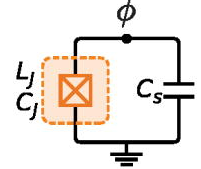

In [ ]:
# We'll use the variable x to represent the offset charge (ng), which will vary from -2.0 to 2.0 
x = np.linspace(-2.0, 2.0, 101)

In [ ]:
# Define a value of the Josephson Energy (E_J) as well as the ratio between the E_J and the Charging Energy (E_C): 
E_J = 1000.0 
ratio = 1.0 
E_C = E_J/ratio 

In [ ]:
# to plot matplotlib in Jupyter cell outputs
%matplotlib inline

# to use LaTeX in matplotlib rendering
plt.rcParams['text.usetex'] = True

In [ ]:
# we'll normalize the calculated energies by the 0->1 transition state energy evaluated at the degenercy point (ng=0.5)
H_norm = Hcpb(nlevels=2, Ej=E_J, Ec=E_C, ng=0.5)
norm = H_norm.fij(0,1)

# Next we'll empty lists to the first three eigenvalues (m=0, m=1, m=2):
E0 = [] 
E1 = [] 
E2 = []

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x: 
    H = Hcpb(nlevels=3, Ej=E_J, Ec=E_C, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)

# define the minimum of E0 and set this to E=0
floor = min(E0) 
 
plt.plot(x, E0 - floor, 'k')
plt.plot(x, E1 - floor, 'r')
plt.plot(x, E2 - floor, 'b')
plt.title('Cooper Pair Box (CPB)')
plt.xlabel(r"Charge offset $n_g$")
plt.ylabel(r"Normalized energy level $E_{m}/E_{01}$")

In [ ]:
# Let's define the range of x-axis values (representating charge) to be from (-5,5) 
x = np.linspace(-5, 5, 100)
 
# Let's plot the first five energy levels (N=0 through N=4) of the harmonic oscillator
# We'll just take L=C=1.0 for simplicity 

plt.plot(x, wavefunction(1.0, 1.0, 0, x), 'k') # N=0; ground state (black)
plt.plot(x, wavefunction(1.0, 1.0, 1, x), 'b') # N=1; first excited state (blue)
plt.plot(x, wavefunction(1.0, 1.0, 2, x), 'r') # N=2; second excited state (red)
plt.plot(x, wavefunction(1.0, 1.0, 3, x), 'g') # N=3; third excited state (green)
plt.plot(x, wavefunction(1.0, 1.0, 4, x), 'y') # N=4; fourth excited state (yellow) 

plt.title("Cooper Pair Box (CPB)")
plt.xlabel(r"Charge offset $n_g$")
plt.ylabel(r"Wavefunction $\psi$")

# show the plot
plt.show()

# (2) Trasnmon type qubit analysis

In [ ]:
import pandas as pd
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic

### Energy levels
We can get a feel for how to use the Hcpb class by plotting the first few eigenvalues as a function of offset charge, similar to the plots reported in Phys. Rev. A 76, 042319 (2007.) Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degenercy point where ng=0.5. For this exercise, we'll take Josephson Energy to be equal to the charging energy:

In [ ]:
# Define a value of the Josephson Energy (E_J) as well as the ratio between the E_J and the Charging Energy (E_C): 
E_J = 1000.0 
ratio = 50 
E_C = E_J/ratio 

Next, we'll sweep over the offset charge and calculate the first three eigenvalues for a given value of ng. We'll need to define a new Hamiltonian for this. 

In [ ]:
# we'll normalize the calculated energies by the 0->1 transition state energy evaluated at the degenercy point (ng=0.5)
H_norm = Hcpb(nlevels=15, Ej=E_J, Ec=E_C, ng=0.5)
norm = H_norm.fij(0,1)

# Next we'll empty lists to the first three eigenvalues (m=0, m=1, m=2):
E0 = [] 
E1 = [] 
E2 = []

# We'll use the variable x to represent the offset charge (ng), which will vary from -2.0 to 2.0 
x = np.linspace(-2.0, 2.0, 101)

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x: 
    H = Hcpb(nlevels=15, Ej=E_J, Ec=E_C, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)

# define the minimum of E0 and set this to E=0
floor = min(E0) 
 
plt.plot(x, E0 - floor, 'k')
plt.plot(x, E1 - floor, 'r')
plt.plot(x, E2 - floor, 'b')
plt.title('Cooper Pair Box (CPB)')
plt.xlabel(r"Charge offset $n_g$")
plt.ylabel(r"Normalized energy level $E_{m}/E_{01}$")

### Comparing with the Analytic Expressions for Energy
We can compare calculated eigenvalues with the analytic solutions by using the "Hcpb_analytic" class, which calculates the transmon eigenvalues analytically using Mathieu characteristic values instead of a matrix-based approach. Let's compare the calculated values of the lowest energy at zero offset charge in both cases:  

In [ ]:
# this is using the Hcpb approach as above, solving the charge basis tridiagonal eigenvalue problem:
H_CPB = Hcpb(nlevels=15, Ej=13971.3, Ec=295.2, ng=0.0)

# this using the Hcpb_analytic class, which solves using the exact (analytic) solutions in terms of Mathieu characteristic values: 
H_CPB_analytic = Hcpb_analytic(Ej=13971.3, Ec=295.2, ng=0.0)

# print and compare energies 
print("E0 (HCPB):", H_CPB.evalue_k(0))
print("E0 (HCPB analytic):", H_CPB_analytic.evalue_k(0))
print("Error:", 100*(H_CPB_analytic.evalue_k(0) - H_CPB.evalue_k(0)) / H_CPB_analytic.evalue_k(0))

As we can see above, the calculated eigenvalues using the Hcbp class match the analytic values extremely well. 
### Wavefunctions 
Let's define a new Hamiltonian, this time with $E_{J} >> E_{C}$ and an offset charge of $ng=0.001$. We can calculate the transition energy between the lowest two states as well as the anharmonicity with the following: 

In [ ]:
H = Hcpb(nlevels=3, Ej=13971.3, Ec=295.2, ng=0.001)
print(f"""
Transmon frequencies 

 ω01/2π = {H.fij(0,1): 6.0f} MHz
   α/2π = {H.anharm(): 6.0f} MHz
""")

Note that both the transition energy and the anharmonicity are read out in units of Megahertz (MHz) 

We can plot the eigenstates (wavefunctions) of the transmon qubit using the commands below: 

In [ ]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=rf"$|{k}\rangle$") # it's in either quadrature, but not both
plt.xlabel(r"Junction phase $\theta$ (wrapped in the interval [$-\pi, \pi$])")
plt.ylabel(r"Re($\psi(\theta)$)")
plt.legend(title="Level")

### Verifying Orthonormality of the Wavefunctions
Here, we can verify the orthonormality of the wavefunctions. Let's first take the first two eigenstates and verify that their inner product is zero, thereby confirming orthogonality. Note that since the wavefunctions can be complex, we need to take the complex conjugate of $\Psi1$. 

In [ ]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))

Indeed, we see that the dot product is essentially zero (within numerical precision.) Next, let's take the inner product of the first eigenstate with itself, checking that we get an output of unity:

In [ ]:
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

# Additional Analysis: Charge Dispersion, Energy Level Differences, Anharmonicity and Dephasing Time ($T_2$)

### (1) Charge dispersion

The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{m}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels and reproduce the figure published in Phys. Rev. A 76, 042319 (2007) (Figure 4(a)). 

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [ ]:
E_c=100.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [ ]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

In [ ]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel(r"$E_j/E_c$")
plt.ylabel(r"$\epsilon_m / E_{01}$ where $\epsilon_m = E_m(n_g=0.5)-E_m(n_g=0.0)$")
plt.legend(title="Energy Level", loc='upper right')

### (2) Energy Level Differences
We can also evaluate the energy level difference ($E_{m0} = E_{m} - E_{0}$) evaluated at the degeneracy point ($n_{g}=0.5$) and compare to Fig. 4(b) of Phys. Rev. A 76, 042319 (2007). To do this, we just need to create empty lists for the energy levels ($E_{0}$ through $E_{3}$) as well as the energy level differences ($E_{00}$ through $E_{30}$.) 

In [ ]:
E00, E10, E20, E30 = [], [], [], [] 
E0, E1, E2, E3 = [], [], [], [] 

Next, we'll sweep over $E_{J}/E_{C}$ from 0 to 140 (using the variable x defined above) and at each point, we'll construct the Hamiltonian and take the difference in eigenvalues evaluated at the degeneracy point $n_{g}=0.5$. We'll also normalize the energy level differences by the charging energy to be consistent with Fig. 4(b) in the above reference: 

In [ ]:
for i in x:
    H = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    E0 = H.evalue_k(0) 
    E1 = H.evalue_k(1)
    E2 = H.evalue_k(2)
    E3 = H.evalue_k(3) 
    E00.append((E0 - E0)/E_c)
    E10.append((E1 - E0)/E_c)
    E20.append((E2 - E0)/E_c)
    E30.append((E3 - E0)/E_c)

In [ ]:
plt.plot(x,E00,'k',label="m0")
plt.plot(x,E10,'b',label="m=1")
plt.plot(x,E20,'g',label="m=2")
plt.plot(x,E30,'r',label="m=3") 
plt.xlabel(r"$E_j/E_c$")
plt.ylabel(r"$E_{m0}/E_c$")
plt.legend(title="Energy Levels", loc='upper right')

### (3) Anharmonicity of a tranmson 

We know that for the transmon qubit, having the Josephson Energy much larger than the charging energy ($E_{J} >> E_{C}$) results in a decrease in anharmonicity. The latter is critical for a functional qubit in which the energy difference between the lowest two states ($E_{01}$) is sufficiently different than the energy difference between the second and third states, $E_{12}$. The absolute anharmonicity is defined as $\alpha = E_{12} - E_{01}$, while the relative anharmonicity is defined as $\alpha_{r} = \alpha/E_{01}$. 

We can easily make a plot of the anharmonicity as a function of $E_{J}/E_{C}$ using the Hcpb class. Let's have the ratio of $E_{J}/E_{C}$ (which we'll call x) vary from 0 to 80, and then we'll create empty lists for $\alpha$ and $\alpha_r$. 

In [ ]:
x = np.linspace(0,80,101)   #EJ/EC
alpha = [] 
alpha_r = [] 

In [ ]:
for i in x:
    H_anharm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    alpha.append(H_anharm.anharm()) 
    alpha_r.append(H_anharm.anharm()/H_anharm.fij(0,1))

Note we get a warning here because the relative anharmonicity blows up as Ej/Ec goes to zero. Then we can plot the results:

In [ ]:
plt.figure(1)
plt.subplot(131)
plt.plot(x,alpha)
plt.xlabel("Ej/Ec")
plt.ylabel(r"Anharmonicity ($\alpha$)") 
plt.subplot(133)
plt.plot(x,alpha_r)
plt.ylim(-0.2, 1.0) 
plt.xlabel("Ej/Ec")
plt.ylabel(r"Relative anharmonicity ($\alpha_r$)")

Indeed we see that the anharmonicity decays with the inverse of $E_{J}/E_{C}$ for small values of $E_{J}/E_{C}$ before reaching a minimum just before $E_{J}/E_{C} \approx 20.0$, then changing sign and approaching zero as $E_{J}/E_{C}$ approaches infinity. This matches very closely to the results found in Figure 5 of Phys. Rev. A 76, 042319 (2007). 

### (4) Dephasing Time ($T_2$) of a transmon qubit

We can estimate the qubit dephasing time (T2) due to charge noise by the following expression: $T_{2} = \frac{\hbar}{A\pi |\epsilon_{1}|}$ where $A$ is on the order of $1E-4$ according to Phys. Rev. A 76, 042319 (2007). Since this is essentially just the inverse of the charge dispersion for $\epsilon_{1}$, we can easily calculate T2 as a function of $E_{J}/E_{C}$ with the following:

In [ ]:
x = np.linspace(0,80,101)     # ratio of Ej/Ec, varying from 0 to 80
T2 = []                       # empty list for T2 

Next, we'll just calculate the T2 time as a function of $E_{J}/E_C{}$, noting that the output of the Hcpb eigenvalue caluclation is in units of E/h ~ MHz (1E6 Hz). So our calculation simplifies to: $T_{2} = \frac{1.0}{2*(1E-4)*(1E6) |\epsilon_{1}|}$ where $\epsilon_{1}$ is the direct output of the Hcpb eigenvalue calculation: 

In [ ]:
E_c = 1000.0 
for i in x: 
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    eps = abs(H_half.evalue_k(1) - H_zero.evalue_k(1))    
    T2.append(1.0/(2.0*(1E-4)*(1E6)*eps) )

plt.plot(x, T2)
plt.yscale("log")
plt.xlabel(r"$E_j/E_c$")
plt.ylabel(r"$T_2$ (sec)")

Indeed, we see that the dephasing time increases exponentially with increasing $E_{J}/E_{C}$, which is one of the critical features of the transmon qubit. By increasing the $E_{J}/E_{C}$ ratio, we reduce sensitivity to charge noise without sacrificing too much anharmonicity, resulting in greatly improved dephasing time. This plot matches very closely to Fig. 5(c) in Phys. Rev. A 76, 042319 (2007).

# LAB HOMEWORK

### Analytic quantum simulations. We will reproduce some results in J koch *et al.,* "Charge-insensitive qubit design derived from the Cooper pair box," *Phys. Rev. A,* **76**, 042319 (2007).
#### DOI: https://doi.org/10.1103/PhysRevA.76.042319 or arXiv: https://arxiv.org/abs/cond-mat/0703002

### NOTE: You should have the same range of X- and Y- variables as in the reference paper (and the units also)

1. Reproduce Fig. 2 of the reference paper
2. Reproduce Fig. 6 of the reference paper
2. Reproduce Fig. 7 of the reference paper